In [2]:
!pip install tpot


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.1 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=b0ed2f686edcd9d7367b36f6966a046252ebc77fb2c34de8c6251b7edc35d289
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [3]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from tpot import TPOTClassifier



import warnings
warnings.filterwarnings("ignore")

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
print (stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()  # Browse and upload the file


Saving archive (10).zip to archive (10).zip


In [7]:
import zipfile
import os

# Define the path of the zip file
zip_file_path = '/content/archive (10).zip'  # Replace with your zip file name

# Extract the contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')  # Extract to a specific folder

print("Extraction completed!")


Extraction completed!


In [10]:
train_news = pd.read_csv('/content/dataset/train.csv')
train_news.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [11]:
test_news = pd.read_csv('/content/dataset/test.csv')
test_news.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [12]:
train_news.shape

(20800, 5)

In [13]:
test_news.shape

(5200, 4)

In [14]:
train_news.isnull().sum()

,0
id,0
title,558
author,1957
text,39
label,0


In [15]:
test_news.isnull().sum()

,0
id,0
title,122
author,503
text,7


**Data Pre-processing**

In [16]:
# replacing the null values with empty string
train_news = train_news.fillna(' ')
test_news = test_news.fillna(' ')

In [17]:
# merging the author name and news title
train_news['content'] = train_news['author']+' '+train_news['title']
test_news['content'] = test_news['author']+' '+test_news['title']

In [18]:
print(train_news['content'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object


In [19]:
print(test_news['content'])

0       David Streitfeld Specter of Trump Loosens Tong...
1         Russian warships ready to strike terrorists ...
2       Common Dreams #NoDAPL: Native American Leaders...
3       Daniel Victor Tim Tebow Will Attempt Another C...
4       Truth Broadcast Network Keiser Report: Meme Wa...
                              ...                        
5195    Jody Rosen The Bangladeshi Traffic Jam That Ne...
5196    Sheryl Gay Stolberg John Kasich Signs One Abor...
5197    Mike McPhate California Today: What, Exactly, ...
5198      300 US Marines To Be Deployed To Russian Bor...
5199    Teddy Wayne Awkward Sex, Onscreen and Off - Th...
Name: content, Length: 5200, dtype: object


**Stemming**

In [20]:
port_stem = PorterStemmer()

In [21]:
def stemming(content):
    stemmed_content = re.sub('^a-zA-Z', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [22]:
train_news['content'] = train_news['content'].apply(stemming)
test_news['content'] = test_news['content'].apply(stemming)

In [23]:
print(train_news['content'])

0        darrel lucu hous dem aide: didn’t even see com...
1        daniel j. flynn flynn: hillari clinton, big wo...
2                  consortiumnews.com truth might get fire
3        jessica purkiss 15 civilian kill singl us airs...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper t.i.: trump ’poster child ...
20796    benjamin hoffman n.f.l. playoffs: schedule, ma...
20797    michael j. de la merc rachel abram macy’ said ...
20798    alex ansari nato, russia hold parallel exercis...
20799                         david swanson keep f-35 aliv
Name: content, Length: 20800, dtype: object


In [24]:
print(test_news['content'])

0       david streitfeld specter trump loosen tongues,...
1       russian warship readi strike terrorist near al...
2       common dream #nodapl: nativ american leader vo...
3       daniel victor tim tebow attempt anoth comeback...
4       truth broadcast network keiser report: meme wa...
                              ...                        
5195    jodi rosen bangladeshi traffic jam never end -...
5196    sheryl gay stolberg john kasich sign one abort...
5197    mike mcphate california today: what, exactly, ...
5198            300 us marin deploy russian border norway
5199     teddi wayn awkward sex, onscreen - new york time
Name: content, Length: 5200, dtype: object


In [25]:
#separating the data and label
X = train_news['content'].values
Y = train_news['label'].values

In [26]:
print(X)

['darrel lucu hous dem aide: didn’t even see comey’ letter jason chaffetz tweet'
 'daniel j. flynn flynn: hillari clinton, big woman campu - breitbart'
 'consortiumnews.com truth might get fire' ...
 'michael j. de la merc rachel abram macy’ said receiv takeov approach hudson’ bay - new york time'
 'alex ansari nato, russia hold parallel exercis balkan'
 'david swanson keep f-35 aliv']


In [27]:
print(Y)

[1 0 1 ... 0 1 1]


In [28]:
Y.shape

(20800,)

**Converting the Textual Data to Numerical Data**

In [29]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
counts = count_vectorizer.fit_transform(train_news['content'].values)
X = transformer.fit_transform(counts)

In [30]:
Y = train_news['label'].values
test_counts = count_vectorizer.transform(test_news['content'].values)
test_tfidf = transformer.fit_transform(test_counts)

In [31]:
print(X)

  (0, 4863)	0.2165218927332343
  (0, 4864)	0.24793148653615255
  (0, 22399)	0.1981484581956435
  (0, 22406)	0.24793148653615255
  (0, 27411)	0.13156850672059783
  (0, 27477)	0.1981484581956435
  (0, 33009)	0.19360181557096778
  (0, 33010)	0.1957612804846955
  (0, 35095)	0.14597825214418644
  (0, 35099)	0.24793148653615255
  (0, 36686)	0.15975360877369998
  (0, 36696)	0.22303997236589798
  (0, 44034)	0.12432900707468589
  (0, 44092)	0.24793148653615255
  (0, 61909)	0.11915729770198633
  (0, 61949)	0.24793148653615255
  (0, 67779)	0.1321079901265965
  (0, 67783)	0.1981484581956435
  (0, 74779)	0.1559330847550666
  (0, 74801)	0.24793148653615255
  (0, 77614)	0.1957612804846955
  (0, 77621)	0.24793148653615255
  (0, 115798)	0.13747300677495586
  (0, 115809)	0.24793148653615255
  (0, 135930)	0.15884719860180038
  :	:
  (20797, 146974)	0.04889695039447585
  (20798, 5477)	0.17329205116131682
  (20798, 5478)	0.18940815584156476
  (20798, 7739)	0.18905688772617318
  (20798, 7780)	0.297024743745

In [32]:
X.shape

(20800, 149839)

In [33]:
print(test_tfidf)

  (0, 33241)	0.21352013132269787
  (0, 33305)	0.37176774852019523
  (0, 77098)	0.4008416526160564
  (0, 88309)	0.08864338808734092
  (0, 88685)	0.09159344849469447
  (0, 103461)	0.4008416526160564
  (0, 119174)	0.31922088484910977
  (0, 119175)	0.31922088484910977
  (0, 125082)	0.37176774852019523
  (0, 131262)	0.08973809446727839
  (0, 133891)	0.11556335066394374
  (0, 138658)	0.31361994032847285
  (0, 146912)	0.09159344849469447
  (0, 146974)	0.09183124629402446
  (1, 5374)	0.2496128099996299
  (1, 87651)	0.2587551692867352
  (1, 87652)	0.3739837984186322
  (1, 105655)	0.27360623911302084
  (1, 105694)	0.3739837984186322
  (1, 112324)	0.2045034765414007
  (1, 112495)	0.33099034911763164
  (1, 125154)	0.2530179414220621
  (1, 125215)	0.3739837984186322
  (1, 129488)	0.2422069522634646
  (1, 141935)	0.31973210567329774
  :	:
  (5197, 131757)	0.3005918316909076
  (5197, 143385)	0.2988456960378733
  (5197, 146912)	0.10484538742318275
  (5197, 146974)	0.10511759032425134
  (5198, 1439)	0.

In [34]:
test_tfidf.shape

(5200, 149839)

**Spliting the data into training and testing data**

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=42)

In [36]:
print(f"Number of Training dataset: {X_train.shape[0]}\nNumber of Testing dataset: {X_test.shape[0]}")

Number of Training dataset: 16640
Number of Testing dataset: 4160


In [37]:
def kfolds(model, model_name):
    model = cross_val_score(model, X,Y, cv=10)
    model_score = np.average(model)
    print(f"{model_name} score on cross validation: {model_score * 100}%")

def train(model, model_name):
    model.fit(X_train, Y_train)
    model_train_score = model.score(X_train, Y_train)
    model_test_score = model.score(X_test, Y_test)
    print(f"{model_name} model score on Training data: {model_train_score * 100}%\n{model_name} model score on Testing data: {model_test_score * 100}%")

def conf_matrix(model):
    Y_pred = model.predict(X_test)
    cm = confusion_matrix(Y_test, Y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True, fmt='.2f');

def class_report(model):
    Y_pred = model.predict(X_test)
    print(classification_report(Y_test, Y_pred))

def roc(model, model_name):
    Y_pred_svm = model.decision_function(X_test)
    svm_fpr, svm_tpr, _ = roc_curve(Y_test, Y_pred_svm)
    auc_svm = auc(svm_fpr, svm_tpr)
    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(svm_fpr, svm_tpr, color="darkorange", label=f'{model_name} (auc = %0.3f)' % auc_svm)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')
    plt.legend()
    plt.show()

**Logistic Regression**

In [38]:
log_model = LogisticRegression()
train(log_model, "Logistic Regression")


Logistic Regression model score on Training data: 99.04447115384616%
Logistic Regression model score on Testing data: 96.77884615384616%


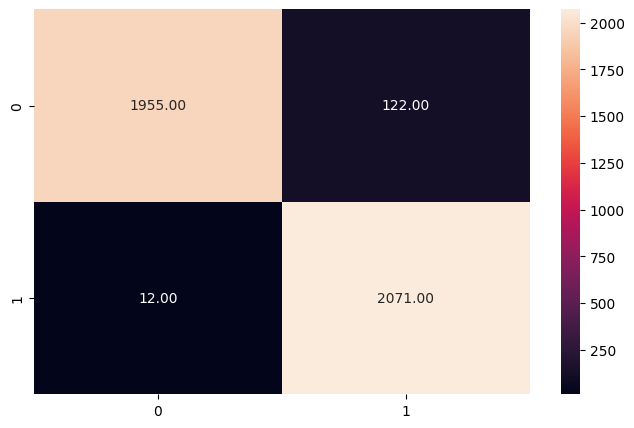

In [39]:
conf_matrix(log_model)

In [40]:
class_report(log_model)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2077
           1       0.94      0.99      0.97      2083

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



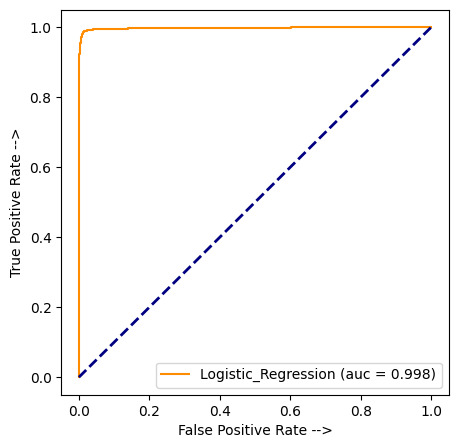

In [41]:
roc(log_model, 'Logistic_Regression')

**SVM Model**

In [42]:
svm_model = SVC()
train(svm_model, 'SV_classifier')

SV_classifier model score on Training data: 99.97596153846153%
SV_classifier model score on Testing data: 98.02884615384615%


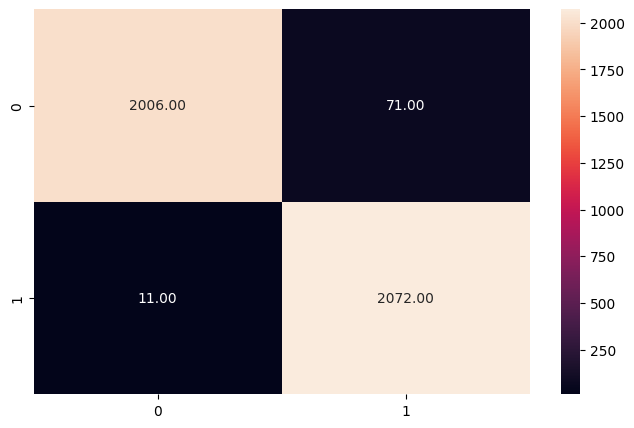

In [43]:
conf_matrix(svm_model)

In [44]:
class_report(svm_model)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2077
           1       0.97      0.99      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



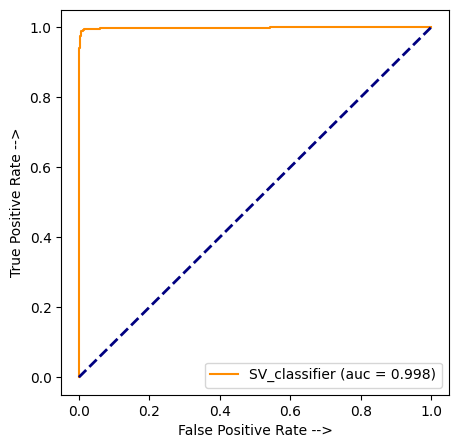

In [45]:
roc(svm_model, 'SV_classifier')

**Decision Tree Classifier Model**

In [46]:
dt_model = DecisionTreeClassifier()
kfolds(dt_model, "Decision_Tree")
train(dt_model, "Decision_Tree")

Decision_Tree score on cross validation: 99.54807692307692%
Decision_Tree model score on Training data: 100.0%
Decision_Tree model score on Testing data: 99.39903846153845%


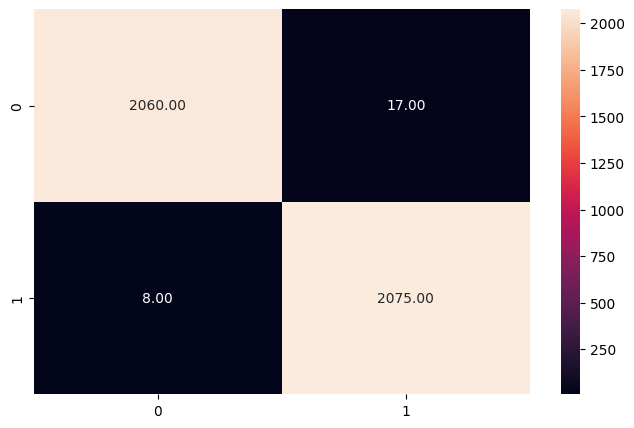

In [47]:
conf_matrix(dt_model)

In [48]:
class_report(dt_model)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2077
           1       0.99      1.00      0.99      2083

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



**Random Forest Classifier**

In [49]:
rf_model = RandomForestClassifier()
train(rf_model, "Random_Forest")

Random_Forest model score on Training data: 100.0%
Random_Forest model score on Testing data: 99.27884615384616%


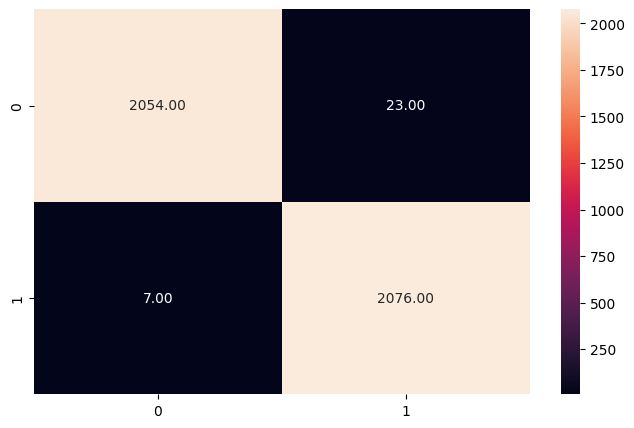

In [50]:
conf_matrix(rf_model)

In [51]:
class_report(rf_model)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2077
           1       0.99      1.00      0.99      2083

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



**K-nearest neighbors**

In [52]:
knn = KNeighborsClassifier()
train(knn, "KNN")

KNN model score on Training data: 96.11778846153847%
KNN model score on Testing data: 93.5576923076923%


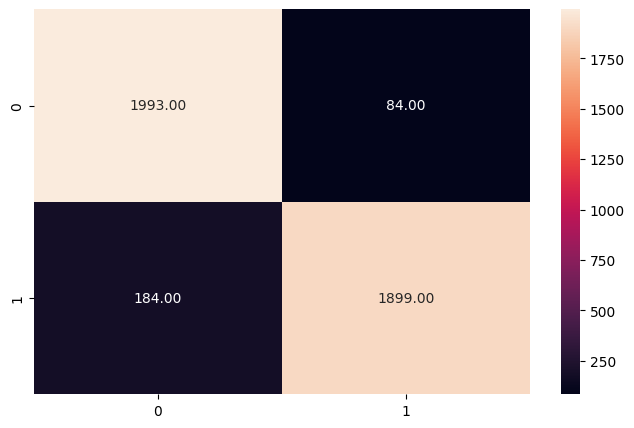

In [53]:
conf_matrix(knn)

In [54]:
class_report(knn)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2077
           1       0.96      0.91      0.93      2083

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



**Naive Bayes**

In [55]:
naive_bayes = MultinomialNB()
kfolds(naive_bayes, "Naive_Bayes")
train(naive_bayes, "Naive_Bayes")

Naive_Bayes score on cross validation: 96.46634615384617%
Naive_Bayes model score on Training data: 99.65745192307692%
Naive_Bayes model score on Testing data: 96.49038461538461%


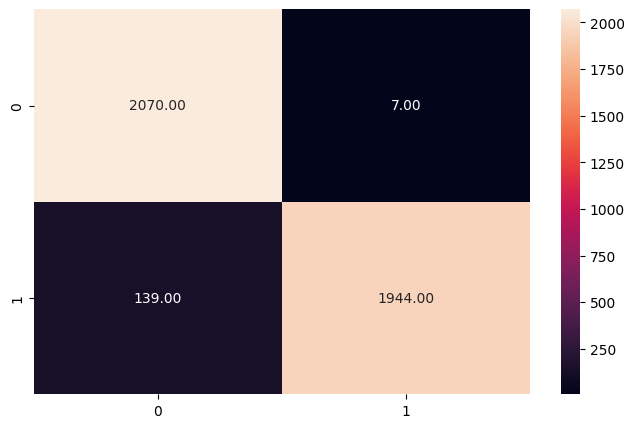

In [56]:
conf_matrix(naive_bayes)

In [57]:
class_report(naive_bayes)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2077
           1       1.00      0.93      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.97      0.96      0.96      4160
weighted avg       0.97      0.96      0.96      4160



In [59]:
# Make predictions --> Logistic Regression
predictions = log_model.predict(test_tfidf)
# Submissions
test_ID = test_news.id
submission = pd.DataFrame({'id' : test_ID, 'label' : predictions})

In [60]:
submission.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [61]:
submission.to_csv("./Logistic Regression.csv", index=False) # Convert the submissions to .csv

In [62]:
# Make predictions -->
predictions = dt_model.predict(test_tfidf)
# Submissions
test_ID = test_news.id
dt_submission = pd.DataFrame({'id' : test_ID, 'label' : predictions})

In [63]:
dt_submission.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [64]:
dt_submission.to_csv("./Decision Tree.csv", index=False) # Convert the submissions to .csv